<a href="https://colab.research.google.com/github/stratos-karas/hello-world/blob/master/final_Dataset_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Δομή notebook**

Η δομή που έχει ακολουθηθεί στο notebook δεν είναι ίδια με τη ζητούμενη και αυτό επειδή βγήκε πιο φυσικό να επικεντρωνόμαστε στον κάθε ταξινομητή για baseline classification και βελτιστοποίηση και μετά να προχωρούμε στον επόμενο.

---
Επομένως η δομή που ακολουθήθηκε είναι η εξής:
1. Ομάδα
2. Απαιτούμενα (εδώ είναι υλοποιημένη η gridsearchcv)
3. Εισαγωγή του Dataset
4. Ταξινομητής:
    1. Baseline Classification(Καμία βελτιστοποίηση)
    2. Βελτιστοποίηση Ταξινομητή

---

# **Στοιχεία Ομάδας**

**Ομάδα Μ.Β.25**
* Ονοματεπώνυμο: Καραπαναγιώτης Ευστράτιος
* Αριθμός Μητρώου: 03115177

#**Απαιτούμενα**

##**Απαραίτητες βιβλιοθήκες**

### **Ενημέρωση βιβλιοθηκών**

In [0]:
!pip install --upgrade pip
!pip install scikit-learn --upgrade
!pip install numpy --upgrade
!pip install pandas --upgrade
!pip install colored --upgrade
!pip install -U imbalanced-learn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 7.0MB 4.6MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.17.4)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for colored: filename=colored-1.4.2-cp36-none-any.whl size=14003 sha256=38cdaf27aa0296c543a23a9903a713635c0c50de7274cf607dd4bb6ed47d427c
  Stored in directory: /root/.cache/pip/wheels/ec/10/5e/d17d5ef644e1051a753bd98f3796789ec39bc3337cd36637f3
Successfully built colored
     |████████████████████████████████| 163kB 5.0MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


### **Εισαγωγή βιβλιοθηκών**

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from colored import fg, attr
import seaborn as sns
import numpy as np
from colored import fg, attr
import functools
import itertools
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


## **Δήλωση προσωπικών συναρτήσεων**

### **Συναρτήσεις για εκτύπωση στην έξοδο**

In [0]:
'''
  Συνάρτηση για όμορφη εκτύπωση ενός αλφαριθμητικού. Το κάνε bold και
  το υπογραμμίζει. Χρησιμοποιείται συνήθως στην έξοδο για να τονίσει συγκεκριμένα
  χαρακτηριστικά. Για να λειτουργήσει πρέπει να εισάγουμε 
  τη βιβλιοθήκη colored. 
'''
from colored import fg, attr

def pprint(string):
  print("%s%s%s" %(fg(0), attr(1), attr(4)), end="")
  print("%s{}%s".format(string) % (fg(0), attr(0)))

In [0]:
'''
  Συνάρτηση για εκτύπωση ενός πίνακα σύγχυσης (confusion matrix) σε μορφή
  heatmap. Για να λειτουργήσει πρέπει να εισάγουμε τις βιβλιοθήκες seaborn
  και matplotlib.pyplot.
'''
def print_confusion_matrix(cnfmatrix):
  matrix = cnfmatrix / cnfmatrix.max()
  fig = plt.figure()
  ax = sns.heatmap(matrix,annot=True,cbar=False,cmap=sns.color_palette("BuGn_r"))
  plt.axes(ax)
  plt.title("Confusion Matrix")
  plt.ylabel("Πραγματικές τιμές")
  plt.xlabel("Προβλεπόμενες τιμές")
  plt.show()

### **Υλοποίηση CrossValidation και GridSearchCV**

In [0]:
'''
  chunk_list(li, n):
    - υπεύθυνη για το κομμάτιασμα μιας λίστας *li* σε επιμέρους λίστες
      πλήθους στοιχείων *n*
  ----------------------------------------------------------------------------
  Eμείς τη χρησιμοποιούμε για να κομματιάσουμε το train set σε «ισομήκη»
  δείγματα τα οποία θα τα χρησιμοποιήσουμε για να εκτελέσουμε cross-validation
  ----------------------------------------------------------------------------
'''
def chunk_list(li, n):
  for i in range(0, len(li), n):
    yield li[i : i+n]

'''
  crossvalidation(clf, X_train_list, y_train_list, folds):
    - η συνάρτηση που εκτελεί το cross validation 
    - δέχεται ως εισόδους τον ταξινομητή *clf* το train set κομματιασμένο στις 
      λίστες *X_train_list* και *y_train_list* σε fold πλήθους κομμάτια
    - διατρέχει όλους τους *fold* συνδιασμούς-διαχωρισμούς στο train set,
      αποθηκεύει σε μια λίστα scores την μετρική προς αξιολόγηση του ταξινομητή
      και επιστρέφει το μέσο όρο αυτής της μετρικής.
    - Η μετρική που επιλέχθηκε είναι η "accuracy=f1-micro" καθώς σύμφωνα με τα 
      docs του scikit-learn το μικρότερο λάθος για multiclass προβλήματα
  ----------------------------------------------------------------------------
  Η συνάρτηση χρησιμοποιείται από μια άλλη που δηλώνεται παρακάτω, τη 
  gridcomputations.
  ----------------------------------------------------------------------------
'''

def crossvalidation(clf, X_train_list, y_train_list, folds):
  scores = []
  for i in range(0, folds):
    # Θεωρούμε τα i-οστά στοιχεία των λιστών X_train_list 
    # και y_train_list ως τα testing set του CV
    X_test, y_test = X_train_list[i], y_train_list[i]
    X_train, y_train = [], []
    
    # Δημιουργούμε μια λίστα αριθμών που περιέχουν τους
    # αιρθυμούς 0..folds πλη  του αριθμού που αντιστοιχεί
    # στα testing sets.
    aux_list = list(range(0, folds))
    del aux_list[i]

    # Διατρέχουμε τη λίστα αυτή για να δημιουργήσουμε τη λίστα
    # με τα X_train και y_train sets.
    for j in aux_list:
      X_train.extend(X_train_list[j])
      y_train.extend(y_train_list[j])

    # Η vstack συγχωνεύει κατευθείαν τη λίστα πινάκων σε
    # έναν ενιαίο πίνακα 
    X_train = np.vstack(X_train)
    y_train = np.array(y_train)

    # Εκπαιδεύουμε και αποθηκεύουμε τη μετρική πρόβλεψης
    # στη λίστα scores
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, pred))
  
  # Επιστρέφουμε το μέσο όρο των scores
  return sum(scores)/len(scores)

'''
  formatdata(X_train, y_train, X_test, selector, scaler, sampler, pca, thres, comp):
    - συνάρτηση που είναι υπεύθυνη για την εφαρμογή των διάφορων σταδίων
      προεπεξεργασίας στα δεδομένα αν και εφόσον υπάρχουν
    - προκειμένου να μην γίνει μετατροπή στα δεδομένα εισόδου X_train, y_train 
      και X_test, καθώς εφαρμόζονται τα στάδια προεπεξεργασίας αποθηκεύουμε
      τα ενδιάμεσα αποτελέσματα με διαφορετικά ονόματα
  ----------------------------------------------------------------------------
  Αυτή η συνάρτηση δημιουργήθηκε προκειμένου:
    1. να αποφευχθεί η κλιμάκωση του κώδικα της συνάρτησης gridcomputations
       για να τον διατηρήσει ευανάγνωστο.
    2. να επιτρέπεται και έξω από τη μέθοδο gridcomputations η εφαρμογή 
       προεπεξεργασίας στα δεδομένα.
  ----------------------------------------------------------------------------
'''
def formatdata(X_train, y_train, X_test, selector=None, scaler=None, sampler=None, pca=None, thres=0, comp=0):
  
  # Selector
  # Επιλογή χαρακτηριστικών
  if selector != None:
    selector.set_params(threshold=thres)
    X_train_sel = selector.fit_transform(X_train)
    X_test_sel = selector.transform(X_test)
  else:
    X_train_sel, X_test_sel = X_train, X_test
    
  '''
    Μετά τη μείωση των χαρακτηριστικών υπολογίζουμε πόσα έχουν μείνει
    για να ενημερώσουμε το PCA για το σε πόσες κύριες συνιστώσεις
    αναλύονται τα δεδομένα μας.
  '''
  _, attrlen = X_train_sel.shape

  # Scaler
  # Κλιμάκωση τιμών
  if scaler != None:
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
  else:
    X_train_scaled, X_test_scaled = X_train_sel, X_test_sel

  # Sampler
  # Εξισορρόπηση dataset
  if sampler != None:
    X_train_sampled, y_train_sampled = sampler.fit_sample(X_train_scaled, y_train)
  else:
    X_train_sampled, y_train_sampled = X_train_scaled, y_train

  # PCA
  # Ανάλυση σε κύριες συνιστώσες
  if pca != None:
    if comp <= attrlen:
      pca.set_params(n_components=comp)
    X_train_pca = pca.fit_transform(X_train_sampled)
    X_test_pca = pca.transform(X_test_scaled)
  else:
    X_train_pca = X_train_sampled
    X_test_pca = X_test_scaled

  # Επέστρεψε τα προεπεξεργασμένα δεδομένα
  return X_train_pca, y_train_sampled, X_test_pca

'''
  gridcomputations(classifier, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, grid):
    - βασικός πυρήνας του gridsearch που επιστρέφει έναν εκπαιδευμένο εκτιμητή 
      με τις βέλτιστες τιμές που μπορούν να λάβουν οι υπερπαράμετροι των 
      μετασχηματιστών (*selecotr*, *scaler*, *sampler*, *pca*) και του 
      ταξινομητή (*classifier*).
    - Ο χώρος αναζήτησης για τις βέλτιστες τιμές των υπερπαραμέτρων δίνεται από
      τη συνάρτηση gridsearchcv ως είσοδος *grid*.
    --------------------------------------------------------------------------
    Αποτελεί ουσιαστικά την υλοποίηση της gridsearchcv αλλά για λόγους
    ιεράρχησης και testing έχει τοποθετηθεί εκτός αυτής και καλείται
    --------------------------------------------------------------------------
'''
def gridcomputations(classifier, X_train, y_train, X_test, y_test, folds, selector=None, scaler=None, sampler=None, pca=None, grid=[]):
  
  # Η λίστα αφορά τα scores της αρχιτεκτονικής για τις διάφορες τιμές
  # που έχουν δοθεί για τις υπερπαραμέτρους της 
  scores = []

  '''
    Αποθηκεύουμε τα δεδομένα προκειμένου αν υποστούν κάποια αλλαγή
    κατα την εφαρμογή των σταδίων προεπεξεργασίας να τα επαναφέρουμε
    στην αρχική τους μορφή, πριν την εφαρμογή κάποια άλλης αρχιτεκτονικής
  '''
  init_X_train = np.copy(X_train)
  init_y_train = np.copy(y_train)
  init_X_test = np.copy(X_test)

  for elem in grid:
    # Το elem δίνεται σε μορφή τούπλας οπότε κάνουμε dereference σε αυτή
    (x, y, z) = elem

    # Παίρνουμε τα νέα δεδομένα μετά την εφαρμογή των σταδίων προεπεξεργασίας
    fmt_X_train, fmt_y_train, fmt_X_test = formatdata(X_train, y_train, X_test, selector, scaler, sampler, pca, x, y)

    # Αν έχουμε τιμή για το z > 0 τότε αφορά τον kNN ταξινομητή
    # Εφαρμόζουμε αλλαγή στις παραμέτρους του
    if z > 0:
      classifier.set_params(n_neighbors=z)

    # Κομματιάζουμε το train set σε μια λίστα από
    # πίνακες πλήθους δειγμάτων chunksize
    chunk_size = len(X_train)//folds + 1
    Xli_train_chunked = list(chunk_list(fmt_X_train, chunk_size))
    yli_train_chunked = list(chunk_list(fmt_y_train, chunk_size))
  
    # Σε αυτό το σηείο μπορούμε να κάνουμε Cross validation
    scores.append(crossvalidation(classifier, Xli_train_chunked, yli_train_chunked, folds))

    # Μετά την ολοκήρωση του crossvalidation για ασφάλεια
    # επαναφέρουμε τα δεδομένα στην αρχική τους μορφή
    X_train = np.copy(init_X_train)
    y_train = np.copy(init_y_train)
    X_test = np.copy(init_X_test)

  '''
    Στο σημείο αυτό βρίσκουμε τις καλύτερες υπερπαραμέτρους.
    Πριν τις δώσουμε στην gridsearchcv ορίζουμε με τις βέλτιστες υπερπαραμέτρους
    την αρχιτεκτονική για να επιστρέψουμε την πρόβλεψη της.
  '''
  # Βρίσκουμε τις υπερπαραμέτρους που βελτιστοποιούν την αρχιτεκτονική 
  maxscore = max(scores)
  bestarch = grid[scores.index(maxscore)]
  x, y, z = bestarch

  # Εκτελούμε ένα τελευταίο τρέξιμο με τις βέλτιστες υπερπαραμέτρους
  # για να εκπαιδεύσουμε τον ταξινομητή
  fmt_X_train, fmt_y_train, fmt_X_test = formatdata(X_train, y_train, X_test, selector, scaler, sampler, pca, x, y)
  # Αν έχουμε τιμή για το z > 0 τότε αφορά τον kNN ταξινομητή
  if z > 0:
    classifier.set_params(n_neighbors=z)

  # Εκπαίδευση ταξινομητή με τις καλύτερες υπερπαραμέτρους σε
  # προεπεξεργαστικό στάδιο κι στον ίδιο
  model = classifier.fit(fmt_X_train, fmt_y_train)

  # Επαναφέρουμε πάλι για λόγους ασφαλέιας τα δεδομένα στην αρχική
  # τους μορφή
  X_train = np.copy(init_X_train)
  y_train = np.copy(init_y_train)
  X_test = np.copy(init_X_test)
  
  '''
    Επιστρέφουμε το maximum score που πέτυχε ο εκτιμητής,
    τις υπερπαραμέτρους της καλύτερης αρχιτεκτονικής
    και το μοντέλο, δηλαδή τον ίδιο τον εκτιμητή εκπαιδευμένο
  '''
  return maxscore, bestarch, model

'''
  create_grid(selparams, pcaparams, clfparams):
    - συνάρτηση υπεύθυνη για τη δημιουργία του χώρους αναζήτησης των 
      υπερπαραμέτρων της αρχιτεκτονικής προεπεξεργασίας
    - η βασική λειτουργία της είναι να επιστρέφει το καρτεσιανό γινόμενο
      των υπερπαραμέτρων που δίνονται σε μορφή λίστας, *selparams*, *pcaparams* 
      και *clfparams* σε λίστα της μορφής [(a1,a2,a3),(b1,b2,b3),...,(w1,w2,w3)] 
      και η προστασία του gridcomputations στην περίπτωση που δε δοθούν λίστες 
      υπερπαραμέτρων.
    - στην περίπτωση που δε δοθούν υπερπαράμετροι επιστρέφει [(0,0,0)]
  ---------------------------------------------------------------------------
  Χρησιμοποιείται από την gridsearchcv προκειμένου να δημιουργήσει τον χώρο
  αναζήτησης των υπερπαραμέτρων που θα μεταβιβάσει στη συνέχεια στην 
  gridcomputations
  ---------------------------------------------------------------------------
'''
def create_grid(selparams=[0], pcaparams=[0], clfparams=[0]):
  if selparams == []:
    selparams = [0]
  
  if pcaparams == []:
    pcaparams = [0]

  if clfparams == []:
    clfparams = [0]

  grid = [(x,y,z) for x in selparams for y in pcaparams for z in clfparams]
  return grid

'''
  gridsearchcv(classifier, X_train, y_train, X_test, y_test, folds, selector, 
                scaler, sampler, pca, selparams, pcaparams, clfparams):
    - Η highlevel απεικόνιση των διαδικασιών gridsearch που παρουσιάστηκαν
      παραπάνω.
    - Αποτελεί την υλοποίηση που ζητήθηκε στην εκφώνηση
    - Δέχεται ως είσοδο έναν ταξινομητή, τα train και test sets, τον αριθμό των
      folds για nfold cross-validation μια αρχιτεκτονική προεπεξεργασίας μαζί
      με τις διάφορες τιμές των υπερπαραμέτρων τους προς εύρεση των βέλτιστων.
    - Εκτυπώνει τις βέλτιστες τιμές των υπερπαραμέτρων του εκτιμητή, δηλαδή της
      αρχιτεκτονικής και τπυ ταξινομητή και επιστρέφει ως έξοδο τον εκτιμητή
      εκπαιδευμένο με τις βέλτιστες υπερπαραμέτρους
  ---------------------------------------------------------------------------
  Η συνάρτηση αυτή χρησιμοποιείται σε όλο το notebook και είναι υπεύθυνη για
  τις crossvalidation δοκιμές των ταξινομητών dummy και kNN. Μπορεί κανείς
  να εκτελέσει τόσο nfold σχήμα CV χωρίς υπερπαραμέτρους αρχιτεκτονικής όσο
  και με υπερπαραμέτρους. Η γενικότητα της υλοποίησης μας gridsearchcv όμως
  είναι περιορισμένη στην εκφώνηση της άσκησης. Δεν είναι δύσκολη βέβαια η
  περαιτέρω γενίκευση και για άλλους ταξινομητές και μετασχηματιστές καθώς 
  υπάρχει ήδη ο γενικός κορμός.
  --------------------------------------------------------------------------- 
'''
def gridsearchcv(classifier, X_train, y_train, X_test, y_test, folds, selector=None, scaler=None, sampler=None, pca=None, selparams=[], pcaparams=[], clfparams=[]):
  # Δημιουργούμε το χώρο αναζήτησης υπερπαραμέτρων
  grid = create_grid(selparams, pcaparams, clfparams)
  # Εκτελούμε την gridcomputations και λαμβάνουμε τα αποτελέσματα
  maxscore, bestarch, model = gridcomputations(classifier, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, grid)
  # Εκτυπώνουμε μάξιμουμ σκορ και βέλτιστες τιμές υπερπαραμέτρων
  print(maxscore, bestarch)
  # Επιστρέφουμε το μοντέλο-εκτιμητή
  return model

#**Παρουσίαση Δεδομένων**

Το dataset αποτελείται από δείγματα που αφορούν 4 κατηγορίες οχημάτων:

1. Δύο επιπέδων λεωφορείο (double decker bus)
2. Cheverolet van
3. Saab 9000
4. Opel Manta 400

Σκοπός είναι με βάση τα 18 χαρακτηριστικά που φέρει κάθε δείγμα να το ταξινομήσουμε στη σωστή κατηγορία.

Τα 18 αυτά χαρακτηριστικά προέκυψαν από το BINATTS (συγκεκριμένα μια επέκτασή του, MDC) ένα εργαλείο που μπορεί να εξάγει χαακτηριστικά μιας εικόνας ανεξάρτητα της κλίμακας τους.

##**Εισαγωγή δεδομένων και προεπεξεργασία**

Πριν την εισαγωγή στην παρκάτω μορφή τα δεδομένα είχαν τις εξής ιδιότητες:
1. Δεν υπήρχαν επικεφαλίδες και αρίθμηση γραμμών, για το λόγο αυτό στη μέθοδο read_csv του panda framework δηλώνουμε ως headers τη λίστα col_names που έχει τα ονόματα τν χαρακηριστικών έτσι όπως αναγράφονται στο UCI ML Repo. Δηλώνουμε επίσης ότι δεν υπάρχει στήλη αρίθμησης γραμμών, διότι υπήρχε μετατόπιση των δεδομένων κατα μία θέση δεξιά ως προς τα χαρκτηριστικά με συνέπεια η στήλη **hollows_ratio** να έχει ως τιμές τις κατηγορίες των οχημάτων και στήλη **vehicle** να έχει Nan τιμές.
2. Οι ετικέτες των κλάσεων βρίσκονται στην στήλη **vehicle** και λαμβάνουν τις τιμές 'bus', 'van', 'saab' και 'opel'.
3. Δεν υπάρχουν τιμές που να απουσιάζουν.
4. Τα δεδομένα ήταν χρισμένα σε 9 διαφορετικά αρχεία της κατάληξης .dat. Έπρεπε επομένως να συμπτίξουμε 9 διαφορετικά dataframes σε ένα dataframe.

###**Εισαγωγή**

In [0]:
import pandas as pd

# Δημιουργία  Dataframe
fd = pd.DataFrame([])

# Δήλωση ονομάτων χαρακυτηριστικών έτσι όπως αναγράφοντα από το UCI ML Repo
col_names = ['compactness', 'circularity', 'dst_circularity', 'radius_ratio', 'axis_aspect_ratio', 'maxlength_aspect_ratio', 'scatter_ratio', 'elongtedness', 'axis_rectangularity', 'maxlength_rectangularity', \
             'scaledvar_major', 'scaledvar_minor', 'scaledradius_gyr', 'skew_major', 'skew_minor', 'kyrtosis_minor', 'kyrtosis_major', 'hollows_ratio', 'vehicle']

# Επειδή οι ονομασίες των αρχείων είναι ίδιες .../xa{a}.dat εκτός από το 
# τελευταίο γράμμα, λουπάρουμε σε όλα τα γράμματα εφαρμόζοντας format 
# στα links εισόδου του read_csv και συνενώνουμε διαδοχικά τα επιμέρους αρχεία
for suffix in 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i':
  dummy_input = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/vehicle/xa{suf}.dat".format(suf=suffix), sep=' ', header=None, names=col_names, index_col=False)
  fd = pd.concat([fd, dummy_input])

print(fd)

    compactness  circularity  ...  hollows_ratio  vehicle
0            95           48  ...            197      van
1            91           41  ...            199      van
2           104           50  ...            196     saab
3            93           41  ...            207      van
4            85           44  ...            183      bus
..          ...          ...  ...            ...      ...
89           93           39  ...            195     saab
90           89           46  ...            197      van
91          106           54  ...            201     saab
92           86           36  ...            195     saab
93           85           36  ...            190      van

[846 rows x 19 columns]


###**Προεπεξεργασία**

In [0]:
# Μετατρέπουμε τα ονόματα των ετικετών σε αριθμούς για την διευκόλυνσή μας
# στην ταξινόμηση των εισόδων 
vehicle_mapping = {'bus': 0, 'van': 1, 'saab': 2, 'opel': 3}
fd['vehicle'] = fd['vehicle'].map(vehicle_mapping)

# Αρχικοποιούμε τις ετικέτες/κατηγορίες
label_names = np.array(['bus', 'van', 'saab', 'opel'])
labels = fd['vehicle'].values

# Αρχικοποιούμε τα χαρακτηριστικά
feature_names = np.array(col_names[:18])
features = np.array([x[:18] for x in fd.values])

pprint("Ονόματα κατηγοριών")
print(label_names)
print()
pprint("Έξοδοι")
print(labels)
print()
pprint("Διαστάσεις εξόδου")
print(labels.shape)
print()

pprint("Ονόματα χαρακτηριστικών")
print(feature_names)
print()
pprint("Είσοδοι")
print(features)
print()
pprint("Διαστάσεις εισόδων")
print(features.shape)
print()

Ονόματα κατηγοριών
['bus' 'van' 'saab' 'opel']

Έξοδοι
[1 1 2 1 0 0 0 1 1 2 1 2 0 1 0 3 1 0 2 3 0 1 0 0 2 1 2 2 0 2 1 2 3 3 3 1 0
 1 2 0 3 1 1 2 2 1 1 0 1 2 2 2 3 0 0 1 2 1 3 1 3 3 1 0 0 3 0 3 1 0 3 3 3 3
 1 3 2 2 0 0 0 0 1 3 0 0 1 1 0 3 2 3 2 1 0 3 2 0 3 0 0 1 1 1 0 2 3 3 0 0 1
 1 3 3 1 1 3 2 0 0 2 1 1 2 1 1 0 0 1 0 2 2 2 1 3 1 1 1 2 1 2 0 3 0 3 3 1 0
 2 1 2 0 3 2 1 0 3 1 2 3 3 3 2 2 3 3 2 2 0 1 3 0 1 0 1 0 3 0 0 1 2 3 0 2 2
 0 0 3 3 3 3 1 2 0 2 0 2 0 0 0 1 2 3 3 1 1 3 0 0 3 3 1 0 0 3 3 2 3 0 1 3 1
 0 0 2 1 2 1 2 2 1 2 0 2 1 1 0 0 3 0 3 3 0 2 1 1 0 2 3 2 1 3 1 0 1 2 2 3 2
 3 2 2 1 1 2 0 0 2 1 1 0 2 1 1 0 0 0 3 2 0 3 0 0 2 1 2 0 1 3 2 1 1 0 1 0 0
 0 2 2 0 2 3 0 1 0 0 2 3 3 3 2 1 0 3 0 1 1 2 1 0 2 0 0 2 2 0 3 3 1 2 1 3 3
 0 0 2 1 0 1 0 0 3 2 3 3 0 2 3 1 3 3 2 1 0 2 3 0 2 3 3 2 2 2 1 3 2 1 2 0 3
 0 0 1 0 1 0 2 2 2 3 3 0 0 3 3 1 2 1 1 3 0 1 1 0 2 3 0 0 0 1 2 3 3 1 3 0 3
 2 0 2 2 3 0 3 1 3 0 0 0 2 1 3 2 0 3 3 3 3 2 1 2 0 2 0 2 1 1 3 3 2 2 1 1 3
 0 1 2 3 0 1 0 3 3 0 2 0 1 1 3 2 1 3 3 3 0 0 

In [0]:
for x in range(0, 4):
  print(list(labels).count(x))

218
199
217
212


1. Σημαντική μετατροπή που έγινε ήταν το mapping των κατηγοριών 'bus', 'van', 'saab', 'opel' στους αριθμούς 0, 1, 2 και 3 αντίστοιχα. Αυτό μας βοήθησε στην καλύτερη παρουσίαση των δεδομένων και αποτελεσμάτων.
2. Παρατηρούμε ότι η κλάση 0 (bus) είναι πιο συχνή από τη 1 (van) κατά $\frac{218}{199} \approx 1.1$. Δηλαδή δεν είναι πλήρως ισορροπημένο το dataset, αλλά μπορεί μπορεί με σωστή διαχείρισή του να μην δημιουργεί πρόβλημα κατά την εκπαίδευση των ταξινομητών.

###**Διαχωρισμός δεδομένων**

Χωρίζουμε από αυτό το σημείο τα δεδομένα μας σε train και test προκειμένου να εξάγουμε από αυτά κάποια συμπεράσματα για να μην προχωράμε τελείως στα τυφλά κατά τα στάδια βελτιστοποίησης.

In [0]:
from sklearn.model_selection import train_test_split

# Χωρίζουμε με τη βοήθεια της βιβλιοθήκης sklearn το dataset σε (train, train_labels) και (test, test_labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

###**Μελέτη δεδομένων**

Θα ελέγξουμε τα δεδομένα μας για διάφορα χαρακτηριστικά πριν την εφαρμογή οποιασδήποτε μεθόδου μετασχηματισμού και εκπαίδευσης σε ταξινομητή

Αρχικά θα κοιτάξουμε για τη μέγιστη διακύμανση μεταξύ των δεδομένων εισόδου προς εκπαίδευση των εκτιμητών

In [0]:
max(X_train.var(axis=0))

29898.192471814757

Παρατηρούμε λοιπόν ότι η μέγιστη διακύμανση είναι $\approx 29800$. Με βάση αυτή την τιμή θα ορίσουμε μια λίστα διακυμάνσεων την οποία μπορεί να χρησιμοποιήσουμε μετά για τη μείωση χαρακτηριστικών με τον VarianceThresholder

In [0]:
thresholds = [0, 2000, 4000, 8000, 12000, 14000, 18000, 20000, 22000, 24000, 28000]

Θα χρσιμοποιήσουμε το PCA για να διακρίνουμε αν υπάρχει κάποια τάση στο dataset μας, μειώνοντας αρχικά τις διαστάσεις για να οπτικοποιήσουμε την είσοδο.

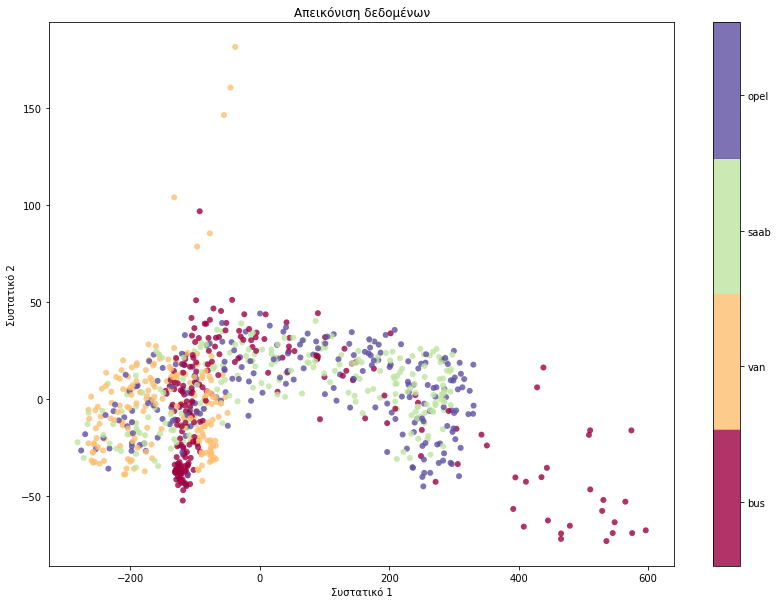

In [0]:
pca = PCA(2)  # project from 18 to 2 dimensions
projected = pca.fit_transform(features)

plt.figure(figsize=(14,10))
plt.title("Απεικόνιση δεδομένων")
s = plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('Spectral',4))
plt.xlabel('Συστατικό 1')
plt.ylabel('Συστατικό 2')
cbar = plt.colorbar()
vmax = s.colorbar.vmax
vmin = s.colorbar.vmin
dst = (vmax-vmin)/4
first = dst - 0.4
cbar.set_ticks([first, first+dst, first+2*dst, first+3*dst])
cbar.set_ticklabels(['bus','van','saab','opel'])
plt.show()

Από την παραπάνω απεικόνιση παρατηρούμε ότι οι 4 κατηγορίες δεν παρουσιάζουν μεγάλες διαφορές στο πως εκφράζονται με τις δύο συνιστώσες. Η κατηγορία 'bus' (δηλαδή η 0) παρουσιάζει μια στενή τάση εξάρτησης από τη Συνιστώσα 2 περισσότερο από τις υπόλοιπες κατηγορίες προμηνύοντας ότι υπάρχουν χαρακτηριστικά που θα μας οδηγήσουν σε γρήγορο διαχωρισμό αυτή της κατηγορίας από τις υπόλοιπες(για το μεγαλύτερο μέρος των δειγμάτων της τουλάχιστον). Υπάρχουν βέβαια και πολλά δεδομένα της τα οποία παρουσιάζουν σημαντική διακύμανση από την κεντρική κατηγορία. Η κατηγορία 'van'(δηλαδή κατηγορία 1) παρουσιάζει σημαντική τοπικότητα (συγκέντρωση γύρω από μια συγκεκριμένη περιοχή) με κάποια δεδομένα να έχουν μεγάλη απόκλιση προς τον άξονα "Συστατικό 2". Άρα και αυτή η κατηγόρια είναι πιθανό να μη δημιουργήσει προβλήματα σημαντικά στην ταξινόμηση. Το μεγαλύτερο πρόβλημα ενδέχεται να δημιουργηθεί από τις κατηγορίες 'saab' και 'opel' καθώς εκφράζονται σε μεγάλο βαθμό με τον ίδιο τρόπο στις δύο βασικές συνιστώσες, οπότε η μείωση των χαρακτηριστικών μπορεί να οδηγήσει σε μεγάλη σύγχυση των δύο κατηγοριών.

Στη συνέχεια θα μελετήσουμε για το PCA τον αριθμό των συνιστωσών σε σχέση με την ποιότητα της πληροφορίας που διατηρείται εκφρασμένη σε διασπορά.

[0.96046578 0.97751685 0.98923746 0.99300581 0.99501097 0.99638748
 0.99751674 0.99829156 0.99893511 0.9992835  0.99955466 0.99972506
 0.99985958 0.99992833 0.99997257 0.99999107 0.99999796 1.        ]


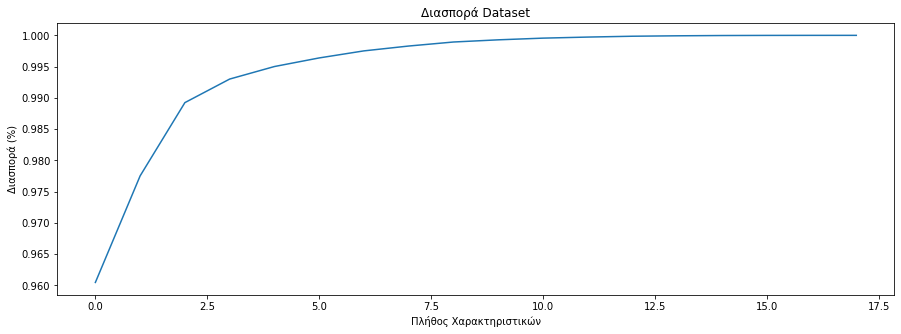

In [0]:
pca = PCA().fit(X_train)#Plotting the Cumulative Summation of the Explained Variance

varlist = np.cumsum(pca.explained_variance_ratio_)
print(varlist)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Πλήθος Χαρακτηριστικών')
plt.ylabel('Διασπορά (%)') #for each component
plt.title('Διασπορά Dataset')
plt.show()

Παρατηρούμε ότι ακόμα και με ένα χαρακτηριστικό η διασπορά διατηρείται σε τιμή μεγαλύτερη του 95% ! Επομένως θα ελέγχουμε για βελτιστοποιήσεις όλες τις δυνατές τιμές του χαρακτηριστικού n_components του PCA.

In [0]:
pcavalues = [i for i in range(1, 19)]

#**Dummy Ταξινομητές**

Αρχικοποιούμε τον dummy ταξινομητή με όλες τις δυνατές στρατηγικές

In [0]:
from sklearn.dummy import DummyClassifier
# Ονομασίες ταξινομητών σε λίστα για την εκτύπωση τους στα bar plots
clasfnames = ['Uniform', 'Constant = bus', 'Constant = van', 'Constant = saab', 'Constant = opel', 'Most freqeuent', 'Stratified']

# Δημιουργούμε στιγμιότυπα του ταξινομητή DummyClassifier
# Ένα στιγμιότυπο για κάθε είδος στρατηγικής
# Αρχικοποίηση όλων των δυνατών dummy ταξινομητών
dc_uniform = DummyClassifier(strategy="uniform")
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")
dc_prior = DummyClassifier(strategy="prior")
dc_constant_bus = DummyClassifier(strategy="constant", constant=0)
dc_constant_van = DummyClassifier(strategy="constant", constant=1)
dc_constant_saab = DummyClassifier(strategy="constant", constant=2)
dc_constant_opel = DummyClassifier(strategy="constant", constant=3)

Δημιουργούμε συνάρτηση **all_dummies** η οποία αναλαμβάνει:
1. Εκπαίδευση με ή χωρίς cross-validation
2. Εκτέλεση προβλέψεων
3. Καταγραφή f1-macro και f1-micro μετρικών για τις προβλέψεις
4. Δημιουργία και εκτύπωση των πινάκων σύγχυσης (confusion matrices)
5. Εκτύπωση bar plots για f1-macro, f1-micro για να συγκρίνουμε τις σταρηγικές μεταξύ τους
6. Εκτύπωση της στρατηγικής που επιφέρει το μεγαλύτερο f1-macro score και το score αυτό
7. Εκτύπωση της στρατηγικής που επιφέρει μεγαλύτερο το f1-micro score και το score αυτό

In [0]:
def all_dummies(X_train, y_train, X_test, y_test, folds=0, selector=None, scaler=None, sampler=None, pca=None, selparams=[], pcaparams=[]):
  
  # Εκπαίδευση των dummy ταξινομητών με ή χωρίς cv
  if folds == 0:
    model_uniform = dc_uniform.fit(X_train, y_train)
    model_constant_bus = dc_constant_bus.fit(X_train, y_train)
    model_constant_van = dc_constant_van.fit(X_train, y_train)
    model_constant_saab = dc_constant_saab.fit(X_train, y_train)
    model_constant_opel = dc_constant_opel.fit(X_train, y_train)
    model_most_frequent = dc_most_frequent.fit(X_train, y_train)
    model_stratified = dc_stratified.fit(X_train, y_train)
  else:
    model_uniform = gridsearchcv(dc_uniform, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_constant_bus = gridsearchcv(dc_constant_bus, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_constant_van = gridsearchcv(dc_constant_van, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_constant_saab = gridsearchcv(dc_constant_saab, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_constant_opel = gridsearchcv(dc_constant_opel, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_most_frequent = gridsearchcv(dc_most_frequent, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
    model_stratified = gridsearchcv(dc_stratified, X_train, y_train, X_test, y_test, folds, selector, scaler, sampler, pca, selparams, pcaparams, [])
  
  # Απόκτηση προβλέψεων και εισαγωγή σε λίστα για ευκολία στις πράξεις
  preds = []
  preds.append(dc_uniform.predict(X_test))
  preds.append(dc_constant_bus.predict(X_test))
  preds.append(dc_constant_van.predict(X_test))
  preds.append(dc_constant_saab.predict(X_test))
  preds.append(dc_constant_opel.predict(X_test))
  preds.append(dc_most_frequent.predict(X_test))
  preds.append(dc_stratified.predict(X_test))

  # Ανάκτηση των ποσοστών επιτυχίας πρόβλεψης του κάθε ταξινομητή
  dummy_scores = []
  dummy_scores.append(accuracy_score(y_test, preds[0]))
  dummy_scores.append(accuracy_score(y_test, preds[1]))
  dummy_scores.append(accuracy_score(y_test, preds[2]))
  dummy_scores.append(accuracy_score(y_test, preds[3]))
  dummy_scores.append(accuracy_score(y_test, preds[4]))
  dummy_scores.append(accuracy_score(y_test, preds[5]))
  dummy_scores.append(accuracy_score(y_test, preds[6]))

  # Confusion matrices
  cnfs = []
  cnfs.append(confusion_matrix(y_test, preds[0]))
  cnfs.append(confusion_matrix(y_test, preds[1]))
  cnfs.append(confusion_matrix(y_test, preds[2]))
  cnfs.append(confusion_matrix(y_test, preds[3]))
  cnfs.append(confusion_matrix(y_test, preds[4]))
  cnfs.append(confusion_matrix(y_test, preds[5]))
  cnfs.append(confusion_matrix(y_test, preds[6]))

  # Υπολογισμός της μετρικής f1 macro και αποθήκευση σε λίστα για 
  # την εκτύπωσή της σε bar plot
  f1_macros = []
  for x in preds:
    f1_macros.append(f1_score(y_test, x, average='macro'))

  # Εκτυπώσεις

  # Ατομικές εκτυπώσεις
  for i in range(0,len(clasfnames)):
    print("%s%s%s" %(fg(0), attr(1), attr(4)), end="")
    print("%s{}%s".format(clasfnames[i]) %(fg(0), attr(0)))
    
    # Confusion matrix
    print_confusion_matrix(cnfs[i])

    print("F1 micro score = {}%".format(dummy_scores[i]*100))
    print("F1 macro score = {}%".format(f1_macros[i]*100))
    print()
  
  # Γενικές εκτυπώσεις
  # Bar plots
  plt.figure(figsize=(12, 5))
  plt.title("F1 micro/accuracy bar plot")
  plt.bar(clasfnames, dummy_scores)
  plt.show()

  print()

  plt.figure(figsize=(12, 5))
  plt.title("F1 macro bar plot")
  plt.bar(clasfnames, f1_macros)
  plt.show()

  print()

  # Max values
  max_score_index = dummy_scores.index(max(dummy_scores))
  max_f1_macro_index = f1_macros.index(max(f1_macros))

  print("Max f1 micro/accuracy είναι {}% για {} τον ταξινομητή".format(dummy_scores[max_score_index]*100, clasfnames[max_score_index]))
  print("Max f1 macro είναι {}% για {} τον ταξινομητή".format(f1_macros[max_f1_macro_index]*100, clasfnames[max_f1_macro_index]))
  
  return dummy_scores

##**Εκπαίδευση χωρίς βελτιστοποίηση**

###**Χωρίς Cross Validation**

Uniform


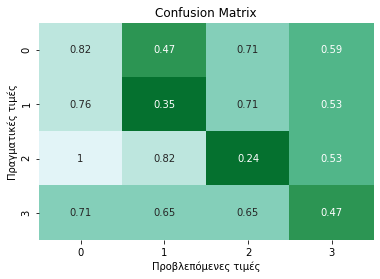

F1 micro score = 18.823529411764707%
F1 macro score = 18.335312036852375%

Constant = bus


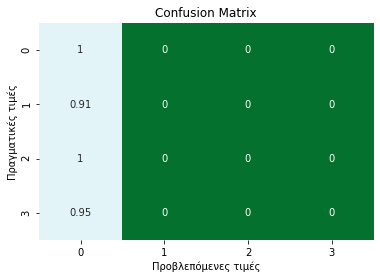

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = van


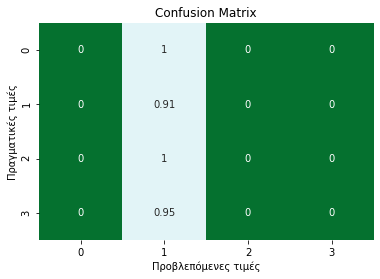

F1 micro score = 23.52941176470588%
F1 macro score = 9.523809523809524%

Constant = saab


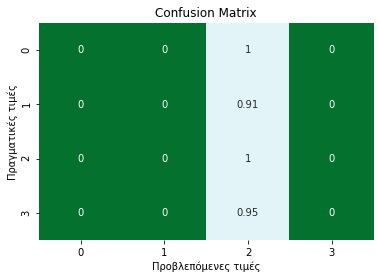

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = opel


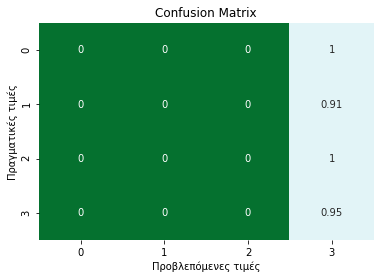

F1 micro score = 24.705882352941178%
F1 macro score = 9.90566037735849%

Most freqeuent


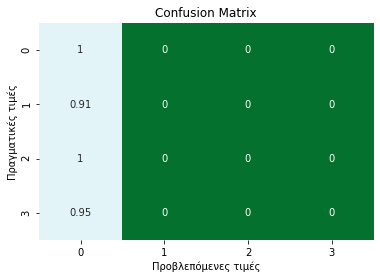

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Stratified


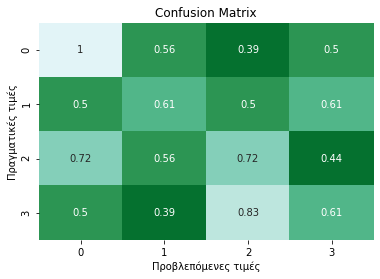

F1 micro score = 31.176470588235293%
F1 macro score = 30.905188499274516%



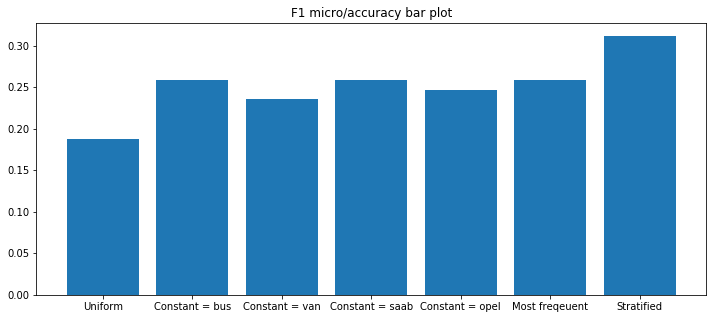

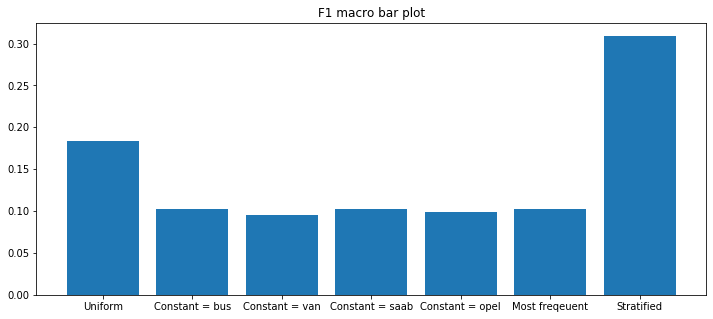


Max f1 micro/accuracy είναι 31.176470588235293% για Stratified τον ταξινομητή
Max f1 macro είναι 30.905188499274516% για Stratified τον ταξινομητή


In [0]:
_ = all_dummies(X_train, y_train, X_test, y_test)

###**Με Cross Validation**

0.27545955882352946 (0, 0, 0)
0.25735294117647056 (0, 0, 0)
0.23520220588235294 (0, 0, 0)
0.25569852941176474 (0, 0, 0)
0.2517463235294118 (0, 0, 0)
0.21893382352941176 (0, 0, 0)
0.2621323529411764 (0, 0, 0)
Uniform


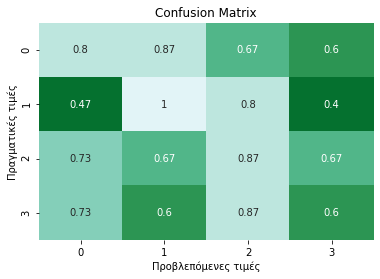

F1 micro score = 28.823529411764703%
F1 macro score = 28.66578320746747%

Constant = bus


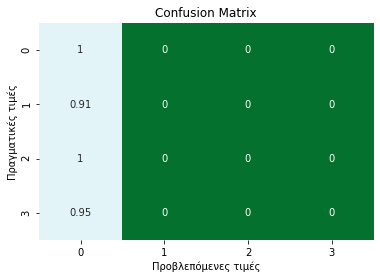

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = van


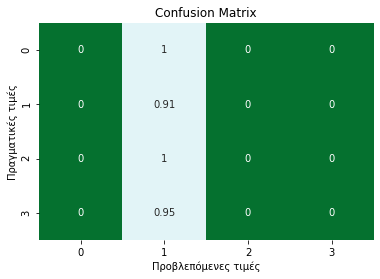

F1 micro score = 23.52941176470588%
F1 macro score = 9.523809523809524%

Constant = saab


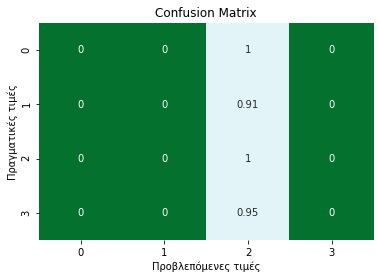

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = opel


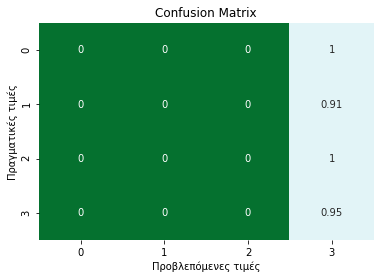

F1 micro score = 24.705882352941178%
F1 macro score = 9.90566037735849%

Most freqeuent


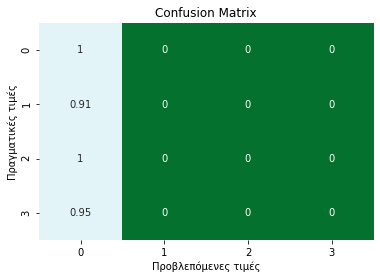

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Stratified


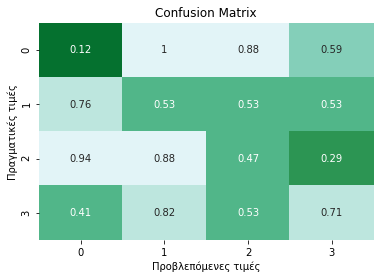

F1 micro score = 18.235294117647058%
F1 macro score = 18.35454434563398%



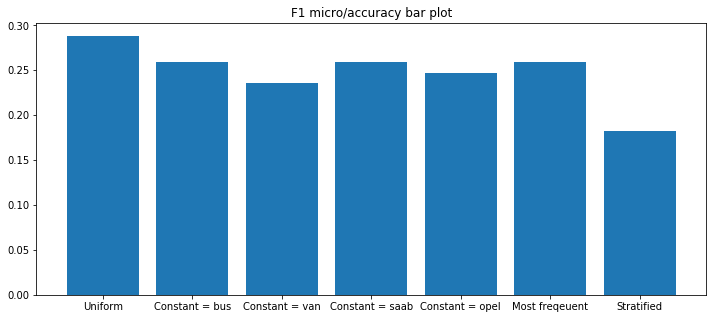

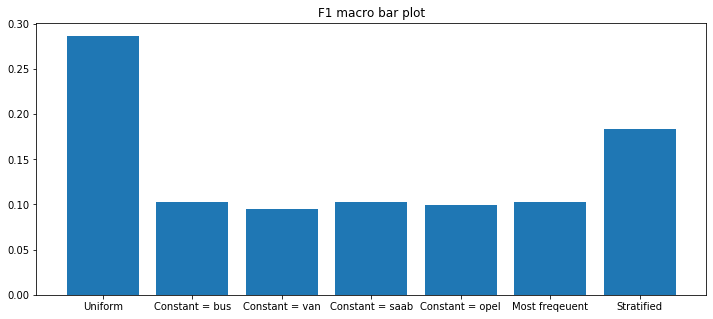


Max f1 micro/accuracy είναι 28.823529411764703% για Uniform τον ταξινομητή
Max f1 macro είναι 28.66578320746747% για Uniform τον ταξινομητή


In [0]:
dummy_accuracies = all_dummies(X_train, y_train, X_test, y_test, folds=10)

##**Εκπαίδευση με βελτιστοποίηση**

Οι dummy classifiers σύμφωνα με το documentation του scikit-learn είναι ταξινομητές που χρησιμοποιούνται κυρίως για να δίνουν στον data scientist μια εικόνα ενός κατώτατου ορίου για τη δημιουργία/εκπαίδευση ενός εκτιμητή. Επιπλέον η ίδια η φύση των ταξινομητών αυτών είναι σχεδόν ανεξάρτητη από τα δεδομένα εισόδου. 

Πιο αναλυτικά:
* Dummy Uniform:
  > Χρησιμποιεί μια uniform κατανομή για τα labels, στο παράδειγμά μας χωρίζει σε $\frac{1}{4}$ την πιθανότητα να βρίσκεται σε κάθε μια από τις 4 κλάσεις.
* Dummy Most frequent:
  > Βρίσκει την πιο συχνή κλάση στο train set και ορίζει αυτή ως την μοναδική πρόβλεψη. Μετατρέπεται σε εναν a posteriori Dummy Constant ταξινομητή.
* Dummy Stratified:
  > Κάνει προβλέψεις με βάση το πως διακυμαίνονται οι κλάσεις στο train set.
* Dummy Constant:
  > Θεωρεί από πριν (a priori) μοναδική κλάση ότι θα είναι η καλύτερη εκτίμηση. Την ορίζει ο προγραμματιστής.

Διαπιστώνεται εύκολα από τα παραπάνω ότι δεν υπάρχει λόγος γα βελτιστοποίηση στους dummy ταξινομητές. Η μοναδική αρχιτεκτονική που θα μπορεί να παρουσιάσει μια μικρή διαφορά στις εκτιμήσεις θα είναι μια που προσθέτει ή αφαιρεί δεδομένα. Αυτή η διαφορά θα παρουσιαστεί επειδή θα εποφεληθεί μια κλάση από τα νέα δείγματα.


Αρχικά βλέπουμε ότι αν  όντως υπάρχει ανομοιογενής κατανομή στις κλάσεις του training set

In [0]:
for x in range(0, 4):
  print(list(y_train).count(x))

174
159
173
170


Υπάρχει οπότε θα χρησιμοποιήσουμε samplers για την εξισσορόπηση αυτών προς τα κάτω και προς τα πάνω 

In [0]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

0.2676470588235294 (0, 0, 0)
0.25588235294117645 (0, 0, 0)
0.23970588235294116 (0, 0, 0)
0.2544117647058824 (0, 0, 0)
0.25 (0, 0, 0)
0.2176470588235294 (0, 0, 0)
0.24705882352941178 (0, 0, 0)
Uniform


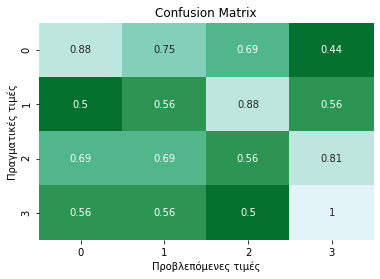

F1 micro score = 28.235294117647058%
F1 macro score = 28.12305087766195%

Constant = bus


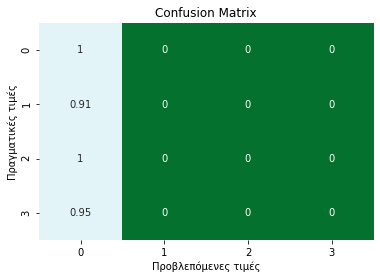

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = van


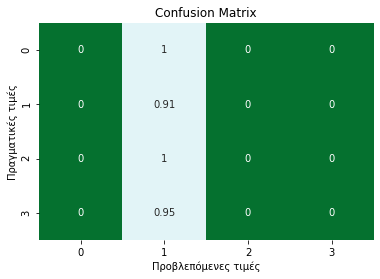

F1 micro score = 23.52941176470588%
F1 macro score = 9.523809523809524%

Constant = saab


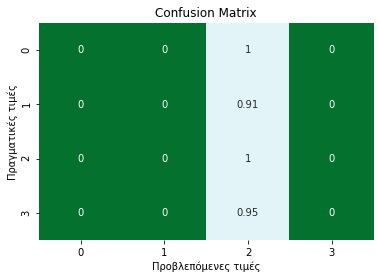

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = opel


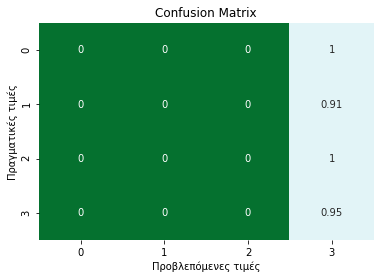

F1 micro score = 24.705882352941178%
F1 macro score = 9.90566037735849%

Most freqeuent


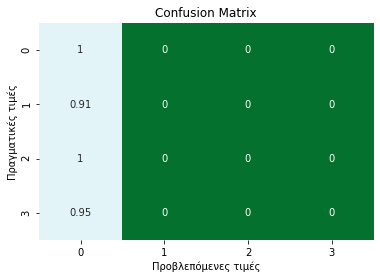

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Stratified


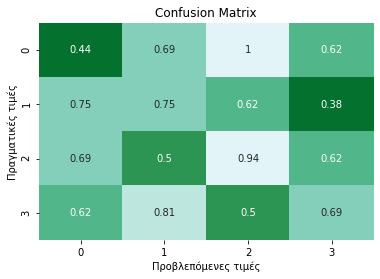

F1 micro score = 26.47058823529412%
F1 macro score = 26.33606525501176%



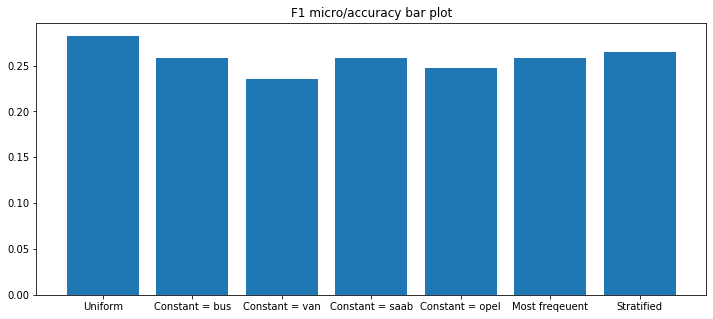

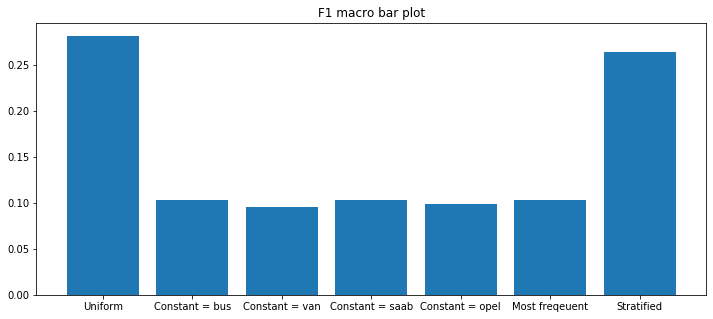


Max f1 micro/accuracy είναι 28.235294117647058% για Uniform τον ταξινομητή
Max f1 macro είναι 28.12305087766195% για Uniform τον ταξινομητή


In [0]:
_ = all_dummies(X_train, y_train, X_test, y_test, folds=10, sampler=ros)

0.236764705882353 (0, 0, 0)
0.2338235294117647 (0, 0, 0)
0.23382352941176468 (0, 0, 0)
0.23382352941176468 (0, 0, 0)
0.2985294117647059 (0, 0, 0)
0.0 (0, 0, 0)
0.16519607843137257 (0, 0, 0)
Uniform


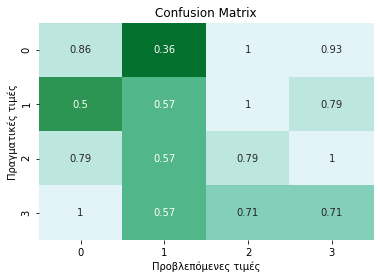

F1 micro score = 24.11764705882353%
F1 macro score = 24.084817317636393%

Constant = bus


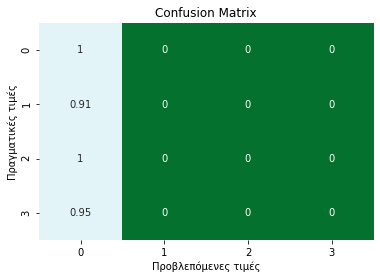

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = van


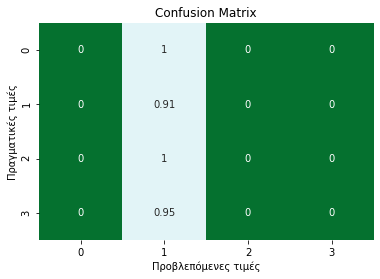

F1 micro score = 23.52941176470588%
F1 macro score = 9.523809523809524%

Constant = saab


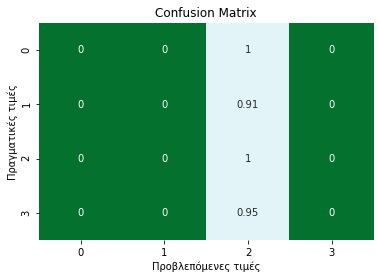

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Constant = opel


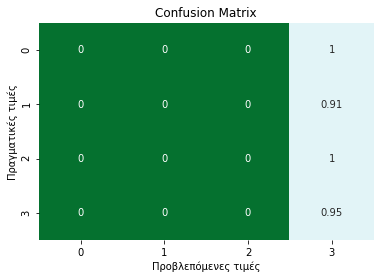

F1 micro score = 24.705882352941178%
F1 macro score = 9.90566037735849%

Most freqeuent


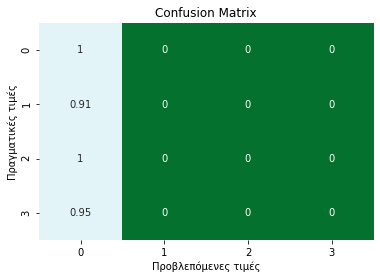

F1 micro score = 25.882352941176475%
F1 macro score = 10.280373831775702%

Stratified


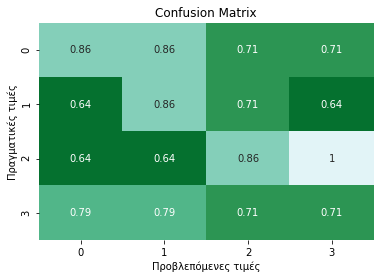

F1 micro score = 27.058823529411764%
F1 macro score = 27.060777799491888%



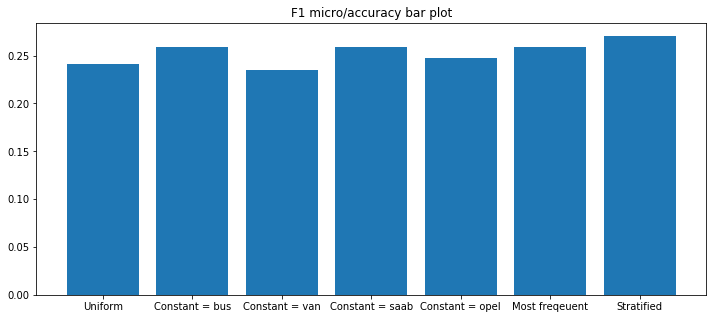

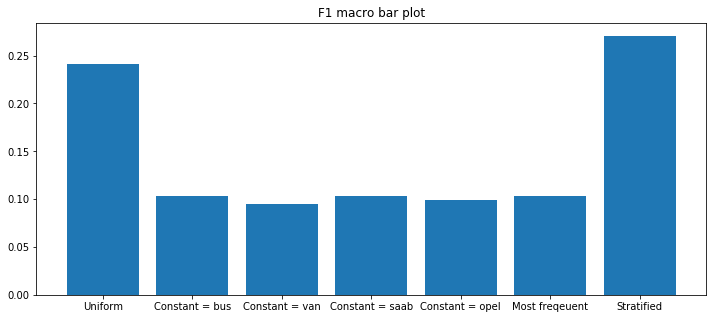


Max f1 micro/accuracy είναι 27.058823529411764% για Stratified τον ταξινομητή
Max f1 macro είναι 27.060777799491888% για Stratified τον ταξινομητή


In [0]:
_ = all_dummies(X_train, y_train, X_test, y_test, folds=10, sampler=rus)

Από τα αποτελέσματα αυτά ήδη μπρούμε να συμπεράνουμε ότι οι dummy classifiers είναι "αναίσθητοι" στις διάφορεςς βελτιστοποιήσεις που μπορεί να γίνονται στα στάδια προεπεξεργασίας. 

Για λόγους πληρότητας να σημειωθεί επίσης οτι όλοι οι dummy ταξινομητές δεν έχουν υπερπαραμέτρους προς βελτιστοποίηση.



#**Ταξινομητής κοντινότερου γείτονα (kNN)**

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)

##**Εκπαίδευση χωρίς βελτιστοποίηση**

KNN Ταξινομητής χωρίς βελτιστοποίηση


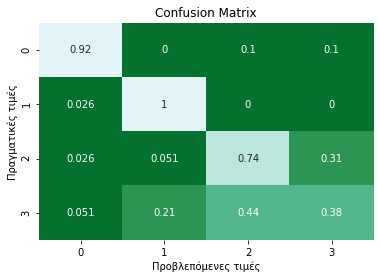

F1 micro/Accuracy score = 0.7%
F1 macro score = 0.6903818830575532%


In [0]:
model = knn.fit(X_train, y_train)
pred = model.predict(X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής χωρίς βελτιστοποίηση")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

##**Εκπαίδευση με βελτιστοποίηση**

Επειδή η εύρεση των καλύτερων υπερπαραμέτρων είναι μια διαδικασία πεπλεγμένη μεταξύ των υπερπαραμέτρων της αρχιτεκτονικής και του ταξινομητή προς εύρεση του τοπικού μεγίστου, θα αρχίσουμε κατευθείαν από τις πλήρεις αρχιτεκτονικές και θα πετάμε σιγά σιγά τα προεπεξεργαστικα στάδια που δεν μας χρειάζονται. 

In [0]:
selector = VarianceThreshold()
scaler_std = StandardScaler()
scaler_mmx = MinMaxScaler()
ros = RandomOverSampler()
rus = RandomUnderSampler()
pca = PCA()

###**Βελτιστοποίηση υπερπαραμέτρου kNN**

Σύμφωνα με τη βιβλιογραφία ο μαξιμουμ αριθμός γειτόνων στον kNN ταξινομητή δεν πρέπει να ξεπερνάει τον αριθμό $\sqrt{N_{samples}} \approx 29$. Επίσης δεν κρατάμε τους άρτιους αριθμούς για το k διότι οδηγεί σε σύγχυση τον ταξινομητή στο διαχωρισμό του dataset.

In [0]:
knnparams = list(filter(lambda x: x%2 != 0, [i for i in range(1, 30)]))

Πριν δημιουργήσουμε το μοντέλο με τη βέλτιστη υπερπαράμετρο k χωρίς στάδια προεπεξεργασίας, θα οπτικοποιήσουμε την τάση της πρόβλεψης τπυ kNN για τις διάφορες τιμές της.

0.6586397058823529 (0, 0, 1)
0.6364889705882353 (0, 0, 3)
0.6329963235294118 (0, 0, 5)
0.6275735294117648 (0, 0, 7)
0.6173713235294117 (0, 0, 9)
0.6125919117647058 (0, 0, 11)
0.6124080882352941 (0, 0, 13)
0.5946691176470588 (0, 0, 15)
0.5843750000000001 (0, 0, 17)
0.5841911764705883 (0, 0, 19)
0.5738970588235295 (0, 0, 21)
0.5899816176470588 (0, 0, 23)
0.5783088235294118 (0, 0, 25)
0.5827205882352942 (0, 0, 27)
0.5900735294117647 (0, 0, 29)



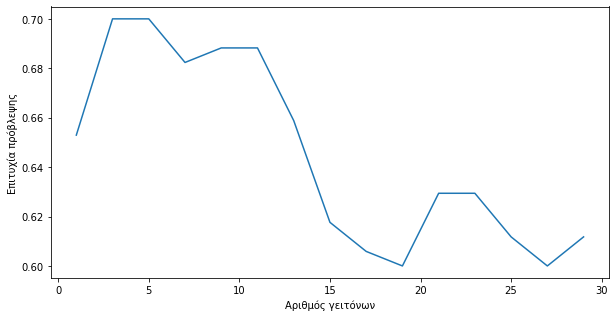

In [0]:
opt_k_scores = []
for k in knnparams:
  kmodel = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, clfparams=[k])
  kpred = kmodel.predict(X_test)
  opt_k_scores.append(accuracy_score(y_test, kpred))

print()
plt.figure(figsize=(10,5))
plt.plot(knnparams, opt_k_scores)
plt.xlabel("Αριθμός γειτόνων")
plt.ylabel("Επιτυχία πρόβλεψης")
plt.show()

In [0]:
opt_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, clfparams=knnparams)

0.6586397058823529 (0, 0, 1)


Παρατηρούμε όντως ότι η βέλτιστη τιμή χωρίς προεπεξεργασία της υπερπαραμέτρου του ταξινομητή είναι 1, όπως φαίνεται και στο διάγραμμα. Η ειδική αυτή περίπτωση με έναν γείτονα ονομάζεται στη βιβλιογραφία ως NearestNeighbor.

KNN Ταξινομητής με βελτιστοποίηση υπερπαραμέτρου k μόνο


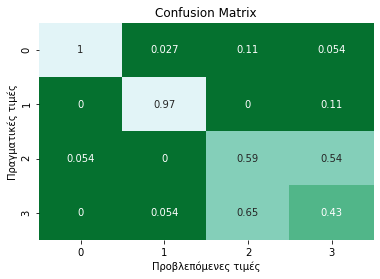

F1 micro/Accuracy score = 0.6529411764705882%
F1 macro score = 0.6629990393647229%


In [0]:
pred = opt_model.predict(X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με βελτιστοποίηση υπερπαραμέτρου k μόνο")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

Παρατηρείται όμως πτώση στην ικανότητά του για πρόβλεψη. Αυτό προκύπτει από το σχήμα του cross validation που ανεξαρτητοποιεί τη διαδικασία της εκπαίδευσης από τα δεδομένα εισόδου. Σε σύγκριση δηλαδή με την άμεση εκπαίδευση όπως κάναμε στην αρχή αυτός ο αριθμός είναι πιο σωστός.

###**Βελτιστοποίηση με απόκλιση χαρακτηριστικών**

In [0]:
opt_var_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, selector=selector, selparams=thresholds, clfparams=[1])

0.6586397058823529 (0, 0, 1)


KNN Ταξινομητής με VarianceThreshold


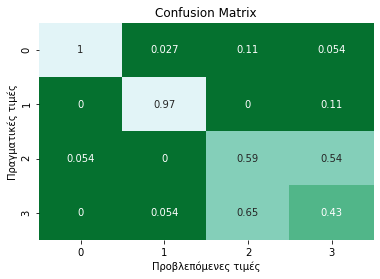

F1 micro/Accuracy score = 0.6529411764705882%
F1 macro score = 0.6629990393647229%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, selector=selector, thres=0) 
pred = opt_var_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με VarianceThreshold")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

In [0]:
print(knn_X_test.shape)

(170, 18)


Με βάση τα αποτελέσματα παρατηρούμε ότι ο VarianceThreshold καταλήγει με τη μέθοδο gridsearchcv να αναζητά και κατα συνέπεια αποκλείει χαρακτηριστικά των οποίων η διασπορά είναι μηδενική. Από την τελευταία εκτύπωση βλέπουμε ότι τα χαρακτηριστικά είναι ίδια σε αριθμό με το αρχικό dataset, δηλαδή 18. Επομένως δεν βλέπουμε να παράγει καλύτερες προβλέψεις η εφαρμογή του στο στάδιο μετασχηματιστών.

###**Βελτιστοποίηση με κανονικοποίηση τιμών**

Αρχικά εφαρμόζουμε τον StandardScaler για την κανονικοποίηση των τιμών, και στη συνέχεια τον MinMaxScaler για να συγκρίνουμε την απόδοσή τους. Να τονισθεί όπως κι στην αρχή ότι ξαναναζητούμε την καλύτερη παράμετρο k για τον ταξινομητή μα καθώς τώρα τα δεδομένα μας έχουν "μετατοπιστεί".

In [0]:
opt_std_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_std,clfparams=knnparams)

0.6955882352941176 (0, 0, 7)


Έχουμε ότι η καλύτερη τιμή του k μετά από standard κανονικοποίηση είναι 7.

KNN Ταξινομητής με StandardScaler


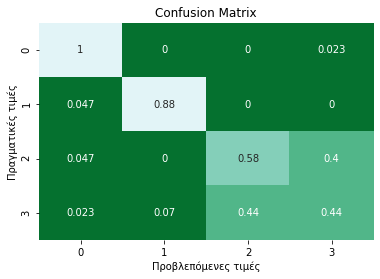

F1 micro/Accuracy score = 0.7352941176470589%
F1 macro score = 0.7305621725108975%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_std) 
pred = opt_std_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με StandardScaler")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

In [0]:
opt_mmx_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_mmx, clfparams=knnparams)

0.6927389705882353 (0, 0, 19)


Έχουμε ότι η καλύτερη τιμή του k μετά από minmax κανονικοποίηση είναι 19.

KNN Ταξινομητής με MinMaxScaler


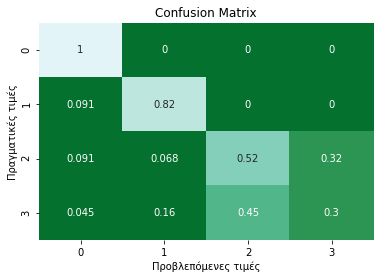

F1 micro/Accuracy score = 0.6823529411764706%
F1 macro score = 0.6601789280964643%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_mmx) 
pred = opt_mmx_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με MinMaxScaler")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

Με τη χρήση κανονικοποίησης παρατηρείται αύξηση του σκορ πρόβλεψης. Αυτό οφείλεται στο ότι ο αλγόριθμος kNN αποφασίζει με τους κοντινότερους γείτονες. Επομένως κανονικοποιώντας το εύρος των τιμών για την ταξινόμηση του έδωσε μεγαλύτερη ευκρίνια. 

Ο StandardScaler οδηγεί σε μεγαλύτερη επιτυχία από τον MinMaxScaler κατά $\approx 5\%$.

Κρατάμε τον StandardScaler αφού απέδωσε καλύτερα.

###**Βελτιστοποίηση με εξισορρόπηση dataset**

In [0]:
for x in range(0, 4):
  print(list(y_train).count(x))

174
159
173
170


Βλέπουμε ότι παρά την εφαρμογή του stratify κατα το διαχωρισμό των δεδομένων σε train και test set υπάρχει ακόμα διακύμανση στις συχνότητες εμφάνισης των κατηγοριών στο train set μας. Για το λόγο αυτό θα εφαρμόσουμε samplers, που θα προσθέτουν (oversampling) ή θα αφαιτρούν (undersampling) δείγματα

In [0]:
opt_ros_std_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_std, sampler=ros, clfparams=knnparams)

0.6985294117647058 (0, 0, 1)


KNN Ταξινομητής με StandardScaler > Oversampling


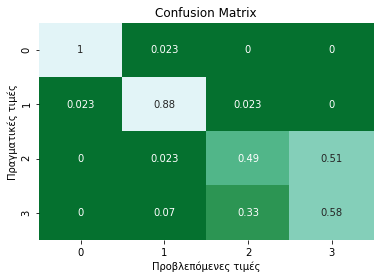

F1 micro/Accuracy score = 0.7470588235294118%
F1 macro score = 0.7449332826710315%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_std, sampler=ros) 
pred = opt_ros_std_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με StandardScaler > Oversampling")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

In [0]:
opt_rus_std_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_std, sampler=rus, clfparams=knnparams)

0.6024509803921568 (0, 0, 1)


KNN Ταξινομητής με StandardScaler > Undersampling


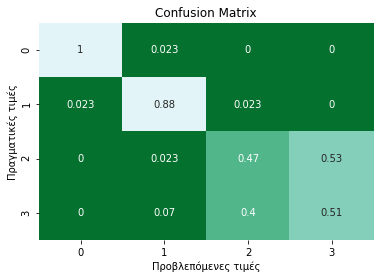

F1 micro/Accuracy score = 0.7235294117647059%
F1 macro score = 0.7216218455901748%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_std, sampler=rus) 
pred = opt_rus_std_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με StandardScaler > Undersampling")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

Προκύπτει επομένως ότι υπάρχει μια μικρή βελτίωση στην πρόβλεψη με τη  εφαρμογή μεθόδων εξισορρόπησης των δειγμάτων του train set. Καλύτερα αποτελέσματα παρουσιάζει η oversampling τεχνική έναντι της undersampling με διαφορά $\approx 2\%$.

Αξίζει να σημειωθεί για ακόμα μια φορά ότι πάλι άλλαξε η τιμή της υπερπαραμέτρου του ταξινομητή και απέκτησε ως βέλτιστη τιμή τον αριθμό 1.

###**Βελτιστοποίηση με PCA**

Τέλος ελέγχουμε αν μπορούμε να μειώσουμε τις κύριες συνιστώσες με τις οποίες εκφράζονται τα δείγματά μας και να λαμβάνουμε τα ίδια ή/και καλύτερα αποτελέσματα στις προβλέψεις μας.

In [0]:
opt_pca_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_std, sampler=ros, pca=pca, pcaparams=pcavalues, clfparams=knnparams)

0.7044117647058824 (0, 16, 5)


KNN Ταξινομητής με StandardScaler > Oversampling > PCA


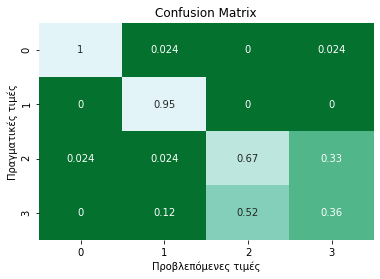

F1 micro/Accuracy score = 0.7352941176470589%
F1 macro score = 0.7243672046955246%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_std, sampler=ros, pca=pca, comp=16) 
pred = opt_pca_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, pred)
pprint("KNN Ταξινομητής με StandardScaler > Oversampling > PCA")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, pred)))
print("F1 macro score = {}%".format(f1_score(y_test, pred, average='macro')))

Με την εφαρμογή της μεθόδου PCA έχουμε μείωση των κύριων χαρακτηριστικών μέσω των οποίων μπορεί να εκφραστούν τα δείγματά μας από 18 σε 16 αλλά έχουμε και πτώση κατα 1% περίπου στην ικανότητά μας για πρόβλεψη.

###**Βέλτιστη αρχιτεκτονική**

Από τα προηγούμενα μπορούμε εύκολα να συμπεράνουμε ότι η καλύτερη αρχιτεκτονική είναι η εφαρμογή κανονικοποίησης με StandardScaler και η εξισορρόπηση δειγμάτων εκπαίδευσης με Oversampling. Επαναλαμβάνουμε την εκπαίδευση παρακάτω προκειμένου να παρουσιάσουμε μια συνολική εικόνα των ταξινομητών που εφαρμόσαμε στο dataset. 

In [0]:
knn = KNeighborsClassifier(n_jobs=-1)
best_model = gridsearchcv(knn, X_train, y_train, X_test, y_test, 10, scaler=scaler_std, sampler=ros, clfparams=knnparams)

0.6985294117647058 (0, 0, 1)


KNN Ταξινομητής με Βέλτιστη Αρχιτεκτονική


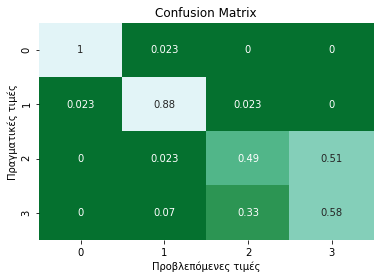

F1 micro/Accuracy score = 0.7470588235294118%
F1 macro score = 0.7449332826710315%


In [0]:
_,_,knn_X_test = formatdata(X_train, y_train, X_test, scaler=scaler_std, sampler=ros) 
best_pred = best_model.predict(knn_X_test)

matrix = confusion_matrix(y_test, best_pred)
pprint("KNN Ταξινομητής με Βέλτιστη Αρχιτεκτονική")
print_confusion_matrix(matrix)
print("F1 micro/Accuracy score = {}%".format(accuracy_score(y_test, best_pred)))
print("F1 macro score = {}%".format(f1_score(y_test, best_pred, average='macro')))

#**Παρουσίαση και σύγκριση αποτελεσμάτων για τους εκτιμητές**

Στο σημείο αυτό για λόγους πληρότητας παρουσιάζουμε όλες τις προβλέψεις των εκτιμητών σε ένα bar plot.

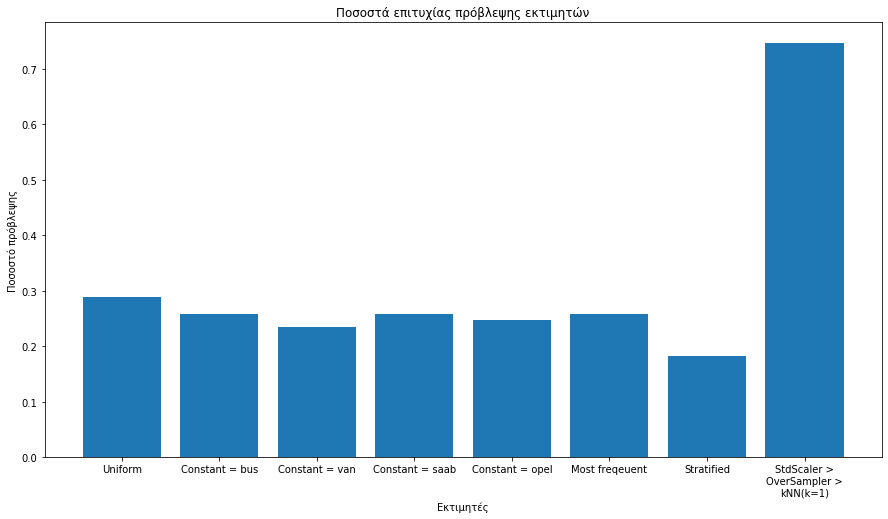

In [0]:
# Αρχικά υπολογίζουμε το score της βέλτιστης αρχιτεκτονικής του kNN
# και στη συνέχεια παρουσιάζουμε τα αποτελέσματα.

knn_best_arch_score = accuracy_score(y_test, best_pred)

allnames = clasfnames.copy()
allnames.append("StdScaler >\nOverSampler >\nkNN(k=1)")

allscores = dummy_accuracies.copy()
allscores.append(knn_best_arch_score)

plt.figure(figsize=(15, 8))
plt.title("Ποσοστά επιτυχίας πρόβλεψης εκτιμητών")
plt.bar(allnames, allscores)
plt.xlabel("Εκτιμητές")
plt.ylabel("Ποσοστό πρόβλεψης")
plt.show()